# You'll learn

## ML methods

- Deep NN with keras

Course [slides](https://github.com/leggerf/MLCourse-2122/blob/master/Slides/Day3/Big%20data%20science%20-%20Day%203%20-%202122.pdf)

In [1]:
%reload_ext custom_magics

#ignore warnings from Tensorflow
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=DeprecationWarning)
import tensorflow as tf
#if type(tf.contrib) != type(tf): tf.contrib._warning = None
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.ml.feature import VectorAssembler

#import Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(1337)  # for reproducibility

# Check out these custom functions
from custom_functions import *

In [2]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-leggerf>

Keras training is not distributed, therefore you cannot feed the largest data sample (10M) or python will go out of memory! This is already a big limitation.  

Still we need spark to be able to read in the input data from HDFS

In [3]:
# read in input data

#inputFile = 'hdfs://192.168.2.39/data/Higgs100k.parquet'
inputFile = 'hdfs://192.168.2.39/data/Higgs1M.parquet'
#inputFile = 'hdfs://192.168.2.39/data/Higgs10M.parquet' # too large, doesn't fit in memory

df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

There are 979519 events


In [4]:
#df.show()
X, y, X_test, y_test = prepareData(df, 0.2)

print('Events for training '+str(len(y)))
print('Events for validation '+str(len(y_test)))

Events for training 783773
Events for validation 195746


In [5]:
# When you're done, stop spark
spark.stop()

# Exercise 1

- documentation: https://keras.io/getting-started/sequential-model-guide/
- Build (compile) a Keras Sequential model (call it *model*)
  - 1 hidden layer  with 100 neurons, activation ReLU (put in the correct input_shape!)
  - 1 ouput layer with activation sigmoid
  - use Adam optimiser
  - use binary_crossentropy loss
  - use accuracy metrics 

In [6]:
# now let's first look at NN in keras

# create the model
model = Sequential()

#baseline, 13m with 1M events, acc 74%, AUC 81
model.add(Dense(100, activation='relu', input_shape=(28,)))
model.add(Dense(1, activation='sigmoid'))
opt = Adam()

# Compile model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [7]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [8]:
%%time
history = model.fit(X, y, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[es]) #, verbose=0)

Epoch 1/10
6124/6124 [==============================] - 21s 3ms/step - loss: 0.6205 - accuracy: 0.6533 - val_loss: 0.6025 - val_accuracy: 0.6700
Epoch 2/10
6124/6124 [==============================] - 22s 4ms/step - loss: 0.5898 - accuracy: 0.6862 - val_loss: 0.5832 - val_accuracy: 0.6932
Epoch 3/10
6124/6124 [==============================] - 19s 3ms/step - loss: 0.5781 - accuracy: 0.6960 - val_loss: 0.5733 - val_accuracy: 0.7032
Epoch 4/10
6124/6124 [==============================] - 24s 4ms/step - loss: 0.5698 - accuracy: 0.7030 - val_loss: 0.5666 - val_accuracy: 0.7051
Epoch 5/10
6124/6124 [==============================] - 25s 4ms/step - loss: 0.5634 - accuracy: 0.7077 - val_loss: 0.5598 - val_accuracy: 0.7122
Epoch 6/10
6124/6124 [==============================] - 21s 3ms/step - loss: 0.5581 - accuracy: 0.7127 - val_loss: 0.5616 - val_accuracy: 0.7115
Epoch 7/10
6124/6124 [==============================] - 18s 3ms/step - loss: 0.5538 - accuracy: 0.7158 - val_loss: 0.5561 - val_ac

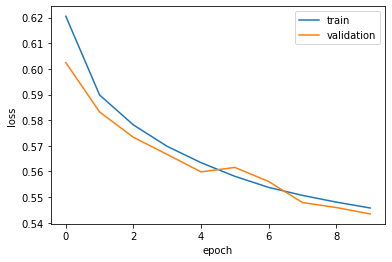

In [9]:
plotVsEpoch(history, 'loss')

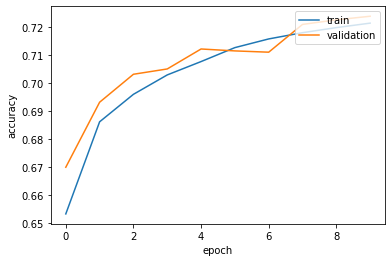

In [10]:
plotVsEpoch(history, 'accuracy')

In [11]:
print(history.params)
print(history.history.keys())


{'verbose': 1, 'epochs': 10, 'steps': 6124}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2900      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________


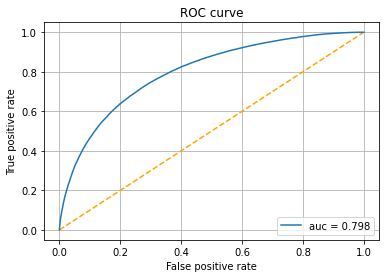

In [13]:
# apply model to get predictions on test set
y_pred = model.predict(X_test)

#draw ROC
drawROC2(y_test, y_pred)

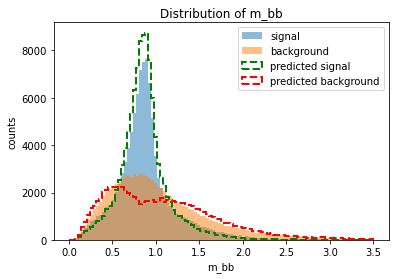

In [14]:
#do signal vs background plot
x_test = X_test[:,25]
variable = 'm_bb'

plotSignalvsBgWithPrediction2(x_test, y_test, y_pred, variable)

# Exercise 2

- play with the model parameters and see if you can improve the performances (try to add hidden layers)
- try to increase the number of epochs for training, is the model improving?
- how is training time affected by the number of parameters?
- how is signal versus background separation affected (check different variables)